Lets start with importing required libraries and datasets

In [ ]:
import numpy as np
import pandas as pd
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Skin_Conditions'
dataset_dir = '/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions'
dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)

    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    test_dataset = dataset.skip(val_end)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Found 2394 files belonging to 6 classes.


In [7]:
# train_dataset.shape()

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

def augment_data(dataset):
    def augment(image, label):
        image = data_augmentation(image)
        return image, label

    return dataset.map(augment)
    
train_dataset = augment_data(train_dataset)

In [10]:

batch_size = 32

train_batches = sum(1 for _ in train_dataset)
val_batches = sum(1 for _ in val_dataset)
test_batches = sum(1 for _ in test_dataset)

total_train_images = train_batches * batch_size
total_val_images = val_batches * batch_size
total_test_images = test_batches * batch_size

print(f"Batch Size: {batch_size}")
print(f"Train Set - Batches: {train_batches}, Total Images: {total_train_images}")
print(f"Validation Set - Batches: {val_batches}, Total Images: {total_val_images}")
print(f"Test Set - Batches: {test_batches}, Total Images: {total_test_images}")


Batch Size: 32
Train Set - Batches: 60, Total Images: 1920
Validation Set - Batches: 7, Total Images: 224
Test Set - Batches: 8, Total Images: 256


**1920 + 224 + 256 = 2400**

**we apply 3 augmented versions per image in the training set, we’ll generate:**


**New images in Train Set = 1920 × 3 = 5760**
saved alongside the original images.

**1920 (original) + 5760 (augmented) = 7680 images**


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 834ms/step - accuracy: 0.3527 - loss: 1.7503 - val_accuracy: 0.7589 - val_loss: 0.7559
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 763ms/step - accuracy: 0.6703 - loss: 0.8961 - val_accuracy: 0.7857 - val_loss: 0.6519
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 769ms/step - accuracy: 0.7628 - loss: 0.6856 - val_accuracy: 0.8080 - val_loss: 0.6007
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 761ms/step - accuracy: 0.7700 - loss: 0.6448 - val_accuracy: 0.8616 - val_loss: 0.4826
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 766ms/step - accuracy: 0.7860 - loss: 0.5674 - val_accuracy: 0.8080 - val_loss: 0.5087
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 767ms/step - accuracy: 0.8248 - loss: 0.4935 - val_accuracy: 0.8705 - val_loss: 0.3767
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 756ms/step - accuracy: 0.8562 - loss: 0.4503 - val_accuracy: 0.8705 - val_loss: 0.3935
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 762ms/step - accuracy: 0.8373 - loss: 0.4269 - val_accu

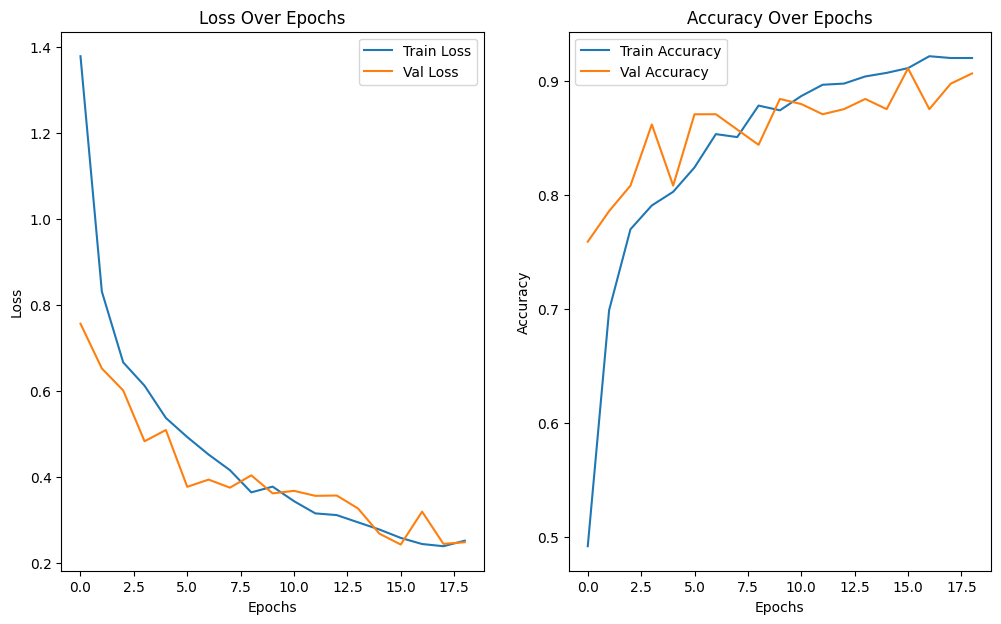

In [11]:

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# early_stopping = EarlyStopping(min_delta=0.01, patience=3, restore_best_weights=True)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]  
)


plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


In [31]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8965 - loss: 0.3015
Test Accuracy: 0.9000


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 849ms/step - accuracy: 0.8745 - loss: 0.3632 - val_accuracy: 0.8884 - val_loss: 0.2837
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 769ms/step - accuracy: 0.9021 - loss: 0.3240 - val_accuracy: 0.9062 - val_loss: 0.2354
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 775ms/step - accuracy: 0.9055 - loss: 0.2865 - val_accuracy: 0.9241 - val_loss: 0.2048
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 790ms/step - accuracy: 0.9285 - loss: 0.2508 - val_accuracy: 0.9330 - val_loss: 0.2368
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 783ms/step - accuracy: 0.9300 - loss: 0.2232 - val_accuracy: 0.9196 - val_loss: 0.2731
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 792ms/step - accuracy: 0.9376 - loss: 0.2046 - val_accuracy: 0.9196 - val_loss: 0.2377


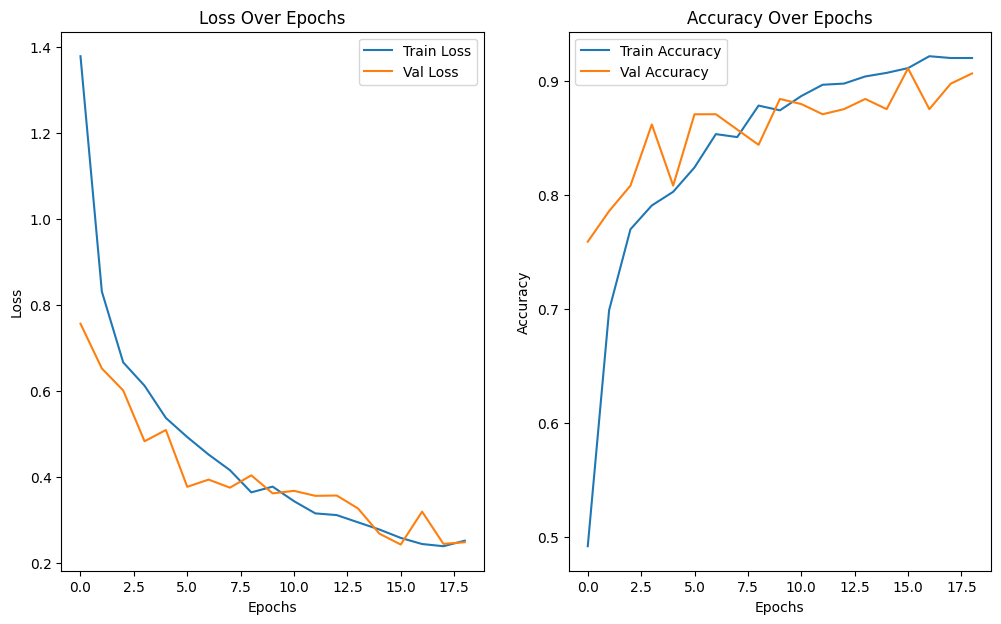

In [13]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [29]:
test_loss, test_acc = model.evaluate(train_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 731ms/step - accuracy: 0.9565 - loss: 0.1687
Test Accuracy: 0.9516


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


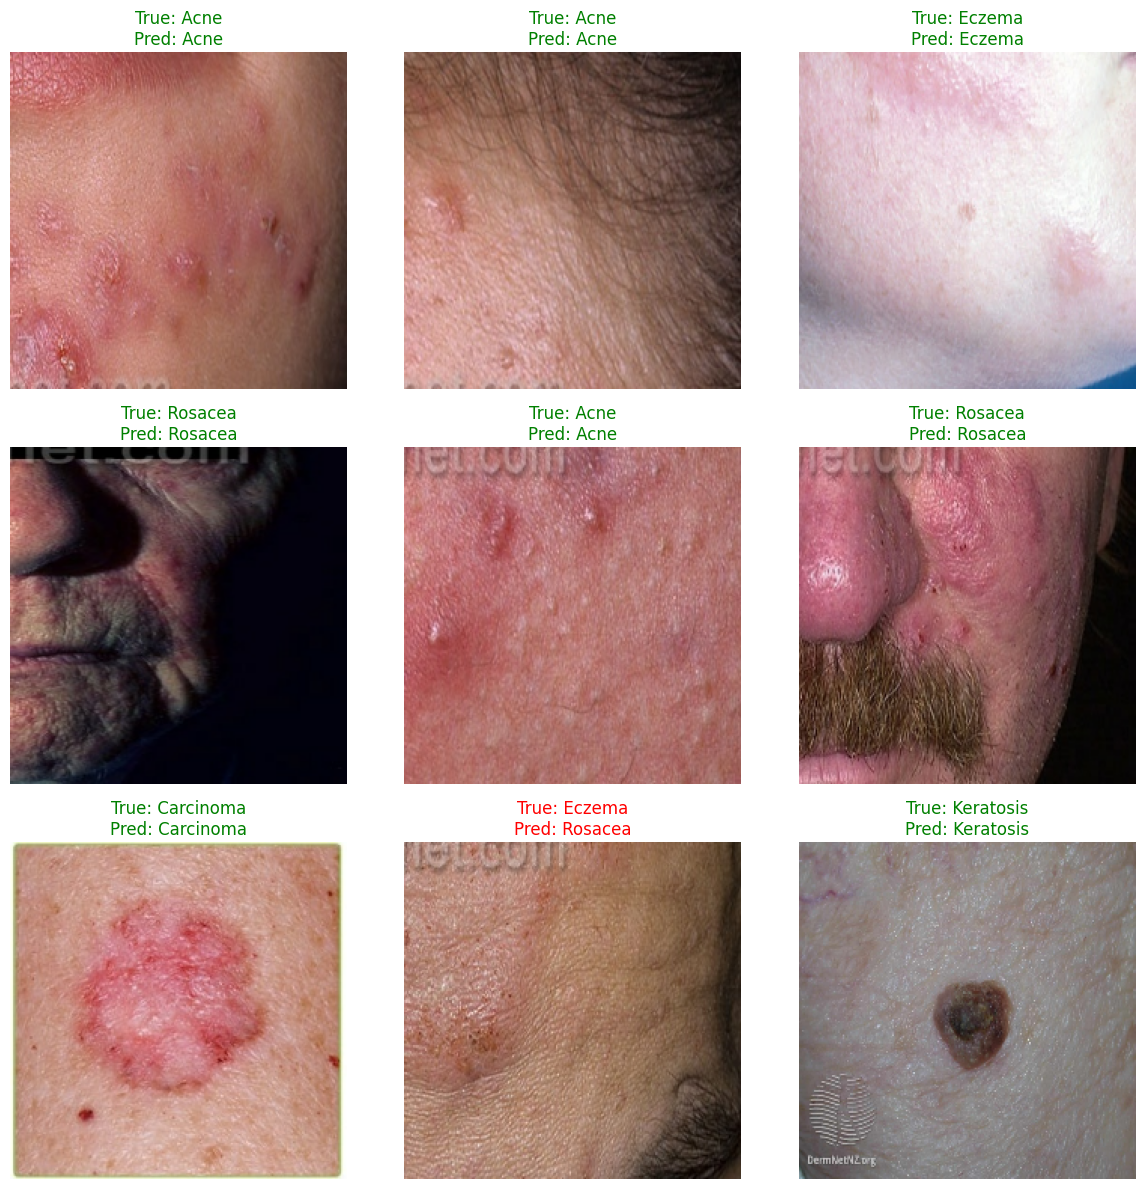

In [19]:
import matplotlib.pyplot as plt

class_names = [
    'Acne',
    'Carcinoma',
    'Eczema',
    'Keratosis',
    'Milia',
    'Rosacea'
]
def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = np.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')
            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)